In [1]:
import geetools
import ee
import geemap
import random
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import math
import os
from datetime import datetime
import skimage
import time
from A1_landsat_functions import *


In [31]:
ee.Authenticate(auth_mode="notebook")

True

In [32]:
ee.Initialize()

In [56]:
#define coordinates to use 
coords_jd = (39.0053612, 21.4210088, 39.3253612, 21.7410088)  # Jeddah
coords_md = (39.4511216, 24.311153, 39.7711216, 24.631153)   # Medina
coords_mk = (39.698,21.078,40.222,21.694)     # Mecca
coords_tf = (40.2558308, 21.1102801, 40.5758308, 21.4302801)   # Taif
#coords_rd 
coords_rd = (46.5560104, 24.478916, 46.8760104, 24.798916) #Riyadh bbox
coord_rd = [[46.4328690955,24.1659202907],[46.6345003059,25.4285645773],[47.5182109888,25.2818982646],
             [47.5209967609,24.1956804525],[46.4328690955,24.1659202907]] #riyad polygon

coords = coords_jd

buffered_coords = add_degree_buffer_to_coords(coords, 0.2)
bbox = ee.Geometry.BBox(*buffered_coords) 
bbox = ee.Geometry.Polygon([coord_rd])

In [58]:
#get Data: Landsat 
# Landsat collections (T1 = Tier 1 Surface Reflectance where available)
landsat1 = ee.ImageCollection("LANDSAT/LM01/C02/T1")
landsat2 = ee.ImageCollection("LANDSAT/LM02/C02/T1")
landsat3 = ee.ImageCollection("LANDSAT/LM03/C02/T1")
landsat4 = ee.ImageCollection("LANDSAT/LT04/C02/T1_L2")
landsat5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
landsat7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")

# Merge Landsat collections based on sensors
landsat_1_3 = landsat1.merge(landsat2).merge(landsat3).filterBounds(bbox).sort("DATE_ACQUIRED")
landsat_4_7 = landsat4.merge(landsat5).merge(landsat7).filterBounds(bbox).sort("DATE_ACQUIRED")
landsat8 = landsat8.filterBounds(bbox).sort("DATE_ACQUIRED")

#Makka
#WRS_PATH = 169
#WRS_ROW = 45
#Jeddah
#WRS_PATH = 170
#WRS_ROW = 45
#riyadh
WRS_PATH = 165
WRS_ROW = 43
landsat_1_3 = landsat_1_3.filter(ee.Filter.And(ee.Filter.eq('WRS_PATH', WRS_PATH),ee.Filter.eq('WRS_ROW', WRS_ROW))).map(lambda img: img.clip(bbox))
landsat_4_7 = landsat_4_7.filter(ee.Filter.And(ee.Filter.eq('WRS_PATH', WRS_PATH),ee.Filter.eq('WRS_ROW', WRS_ROW))).map(lambda img: img.clip(bbox))
landsat8    = landsat8.filter(ee.Filter.And(ee.Filter.eq('WRS_PATH', WRS_PATH),ee.Filter.eq('WRS_ROW', WRS_ROW))).map(lambda img: img.clip(bbox))

#apply processing for cloud mask and rename bands
landsat_4_7 = landsat_4_7.map(maskL457sr).map(rescaleL457sr).map(renameL457)
landsat8 = landsat8.map(maskL8sr).map(rescaleL8sr).map(renameL8sr)
#merge landsat data sets 
landsat = landsat_4_7.merge(landsat8)

#apply diffent indices 
landsat_indexed = landsat.map(apply_indices)

#Add LST
landsat_indexed = landsat_indexed.map(add_lst)

In [59]:
exclude_ids = ['1_1_2_LT05_170045_19871122', '1_1_2_LT05_170045_19881226', '2_LC08_170045_20160801', '1_1_2_LT05_169045_19960312', 
               '2_LC08_169045_20200720', '1_1_2_LT05_169045_19840903', '2_LC08_169045_20220115', '1_2_LE07_165043_20190511', 
               '1_1_2_LT05_170045_19970202', '1_2_LE07_170045_20230410']
landsat_indexed = landsat_indexed.filter(ee.Filter.inList('system:index', exclude_ids).Not())


In [60]:
# get urban mask 
ghsl = ee.ImageCollection("JRC/GHSL/P2023A/GHS_BUILT_S").select("built_surface")
available_years = ee.List([1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030])
# Function to find the nearest available GHSL year
def get_nearest_year(target_year):
    def reducer(closest, current):
        closest = ee.Number(closest)
        current = ee.Number(current)
        closest_diff = target_year.subtract(closest).abs()
        current_diff = target_year.subtract(current).abs()
        return ee.Algorithms.If(current_diff.lt(closest_diff), current, closest)
    
    return ee.Number(available_years.iterate(reducer, available_years.get(0)))
# Function to get GHSL image for nearest year
def get_nearest_ghsl_image(date):
    year = ee.Date(date).get('year')
    closest_year = get_nearest_year(year)
    return ghsl.filter(ee.Filter.calendarRange(closest_year, closest_year, 'year')).first()
# Function to add urban mask band
def add_urban_mask(img):
    ghsl_img = get_nearest_ghsl_image(img.date())
    urban_mask = ghsl_img.select('built_surface').gt(500).rename('urban_mask').clip(bbox)  # Built-up area 500 m^2 
    return img.addBands(urban_mask)
# Apply to collection
landsat_indexed = landsat_indexed.map(add_urban_mask)

'''
# also include all cells within the cite 
# Define city center (example: Riyadh)
city_center = ee.Geometry.Point([46.6753, 24.7136])  
# Create a 30 km buffer
buffer_km = 30 * 1000  # meters
urban_buffer = city_center.buffer(buffer_km)
# Create a mask of pixels within the buffer
urban_buffer_mask = ee.Image.constant(1).clip(urban_buffer).rename("urban_buffer")
# Combine with your existing urban mask (from GHSL or other source)
# Assuming `urban_mask` is your binary mask (1 = urban, 0 = non-urban)
# If not already binary, make sure to threshold your GHSL properly before this
# Combine masks: 1 if either mask is urban
combined_urban_mask = urban_mask.max(urban_buffer_mask)
# Visualize 
urban_vis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red']
}
Map = geemap.Map(center=[24.6, 46.7], zoom=8)
Map.centerObject(city_center, 10)
Map.addLayer(combined_urban_mask, urban_vis, 'Extended Urban Mask')
Map
'''

'\n# also include all cells within the cite \n# Define city center (example: Riyadh)\ncity_center = ee.Geometry.Point([46.6753, 24.7136])  \n# Create a 30 km buffer\nbuffer_km = 30 * 1000  # meters\nurban_buffer = city_center.buffer(buffer_km)\n# Create a mask of pixels within the buffer\nurban_buffer_mask = ee.Image.constant(1).clip(urban_buffer).rename("urban_buffer")\n# Combine with your existing urban mask (from GHSL or other source)\n# Assuming `urban_mask` is your binary mask (1 = urban, 0 = non-urban)\n# If not already binary, make sure to threshold your GHSL properly before this\n# Combine masks: 1 if either mask is urban\ncombined_urban_mask = urban_mask.max(urban_buffer_mask)\n# Visualize \nurban_vis = {\n    \'min\': 0,\n    \'max\': 1,\n    \'palette\': [\'white\', \'red\']\n}\nMap = geemap.Map(center=[24.6, 46.7], zoom=8)\nMap.centerObject(city_center, 10)\nMap.addLayer(combined_urban_mask, urban_vis, \'Extended Urban Mask\')\nMap\n'

In [42]:
# Print a sample image with the mask
sample = landsat_indexed.first().clip(bbox)
Map = geemap.Map(center=[24.6, 46.7], zoom=8)
Map.addLayer(sample.select('urban_mask'))
Map.centerObject(sample, 10)
Map

Map(center=[21.580839758630017, 39.16536120000002], controls=(WidgetControl(options=['position', 'transparent_…

In [36]:
# Print a histogram of urban_mask values over a region
stats = sample.select('urban_mask').reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=sample.geometry(),
    scale=30,  # Match your image resolution
    maxPixels=1e9
)

print("Urban mask value distribution:", stats.getInfo())


Urban mask value distribution: {'urban_mask': {'0': 3913082.5647058827, '1': 372771.02352941176}}


In [61]:
#SUHI as property to image collection 
# similar to https://www.sciencedirect.com/science/article/pii/S1364682620301851 
def compute_suhi(image):
    urban_mask = image.select('urban_mask')
    
    # Apply masks
    urban_temp = image.select('LST').updateMask(urban_mask)
    nonurban_temp = image.select('LST').updateMask(urban_mask.Not())

    # Compute means
    urban_mean = urban_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=image.geometry(),
        scale=30,
        maxPixels=1e13
    ).get('LST')

    nonurban_mean = nonurban_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=image.geometry(),
        scale=30,
        maxPixels=1e13
    ).get('LST')

    # Compute SUHI
    suhi = ee.Number(urban_mean).subtract(ee.Number(nonurban_mean))

    # Attach SUHI as a new property
    return image.set({'SUHI': suhi})
#add SUHI as metadata to landsat indexed    
landsat_suhi = landsat_indexed.map(compute_suhi)
#or just create a feature collection 
suhi_fc = landsat_indexed.map(compute_suhi).map(lambda img: ee.Feature(None, {
    'date': img.date().format('YYYY-MM-dd'),
    'SUHI': img.get('SUHI')
}))


In [54]:
#Turn the property into a csv table 

def fc_to_array_batched(fc, properties, chunk_size=40, sleep_time=5):
    n = fc.size().getInfo()
    num_chunks = math.ceil(n / chunk_size)
    all_data = []

    for i in range(num_chunks):
        print(f"Fetching batch {i+1}/{num_chunks}")
        batch_fc = ee.FeatureCollection(fc.toList(chunk_size, i * chunk_size))

        # Map to Features with only desired properties
        def extract_props(feat):
            return ee.Feature(None, {key: feat.get(key) for key in properties})

        batch_props_fc = batch_fc.map(extract_props)

        # Get the list of Features in this batch
        features_list = batch_props_fc.toList(batch_fc.size())

        try:
            # GetInfo on the list to bring it client-side
            features_client = features_list.getInfo()

            # For each feature, extract the properties
            for feat in features_client:
                props = feat['properties']
                all_data.append({key: props.get(key) for key in properties})

        except Exception as e:
            print(f"Batch {i+1} failed: {e}")
            continue

        time.sleep(sleep_time)

    df = pd.DataFrame(all_data)
    return df, df[properties].dropna().to_numpy()


In [62]:
properties = ['DATE_ACQUIRED', 'SUHI']
# Convert to DataFrame and NumPy array
df_suhi, suhi_array = fc_to_array_batched(landsat_suhi, properties, chunk_size=30, sleep_time=10)
# Save as CSV
df_suhi.to_csv("suhi_timeseries_rd.csv")

Fetching batch 1/34
Batch 1 failed: Collection.toList: Error in map(ID=1_1_2_LT05_165043_19850505):
Image.constant: Parameter 'value' is required and may not be null.
Fetching batch 2/34
Batch 2 failed: Collection.toList: Error in map(ID=1_1_2_LT05_165043_19850505):
Number.subtract: Parameter 'left' is required and may not be null.
Fetching batch 3/34
Batch 3 failed: Collection.toList: Error in map(ID=1_1_2_LT05_165043_19850505):
Image.constant: Parameter 'value' is required and may not be null.
Fetching batch 4/34
Batch 4 failed: Collection.toList: Error in map(ID=1_1_2_LT05_165043_19850505):
Image.constant: Parameter 'value' is required and may not be null.
Fetching batch 5/34
Batch 5 failed: Collection.toList: Error in map(ID=1_1_2_LT05_165043_19850505):
Image.constant: Parameter 'value' is required and may not be null.
Fetching batch 6/34
Batch 6 failed: Collection.toList: Error in map(ID=1_1_2_LT05_165043_19850505):
Image.constant: Parameter 'value' is required and may not be null

KeyError: "None of [Index(['DATE_ACQUIRED', 'SUHI'], dtype='object')] are in the [columns]"

In [ ]:
#normalized SUHI as in https://www.mdpi.com/2073-4433/16/6/712
def compute_normalized_suhi(image):
    urban_mask = image.select('urban_mask')
    
    # Masked LST images
    urban_temp = image.select('LST').updateMask(urban_mask)
    nonurban_temp = image.select('LST').updateMask(urban_mask.Not())
    
    # Compute means and stddev for nonurban pixels
    reducer = ee.Reducer.mean().combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    )
    
    stats = nonurban_temp.reduceRegion(
        reducer=reducer,
        geometry=image.geometry(),
        scale=30,
        maxPixels=1e13
    )
    
    nonurban_mean = ee.Number(stats.get('LST_mean'))
    nonurban_std = ee.Number(stats.get('LST_stdDev'))
    
    # Compute urban mean
    urban_mean = urban_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=image.geometry(),
        scale=30,
        maxPixels=1e13
    ).get('LST')
    
    # Avoid division by zero or null std dev
    suhi = ee.Algorithms.If(
        nonurban_std.gt(0),
        ee.Number(urban_mean).subtract(nonurban_mean).divide(nonurban_std),
        None
    )
    
    return image.set({'SUHI_normalized': suhi})
landsat_norm_suhi = landsat_indexed.map(compute_normalized_suhi)

properties = ['DATE_ACQUIRED', 'SUHI_normalized']
# Convert to DataFrame and NumPy array
df_suhi, suhi_array = fc_to_array_batched(landsat_norm_suhi, properties, chunk_size=30, sleep_time=10)
# Save as CSV
df_suhi.to_csv("suhi_norm_timeseries_rd.csv")

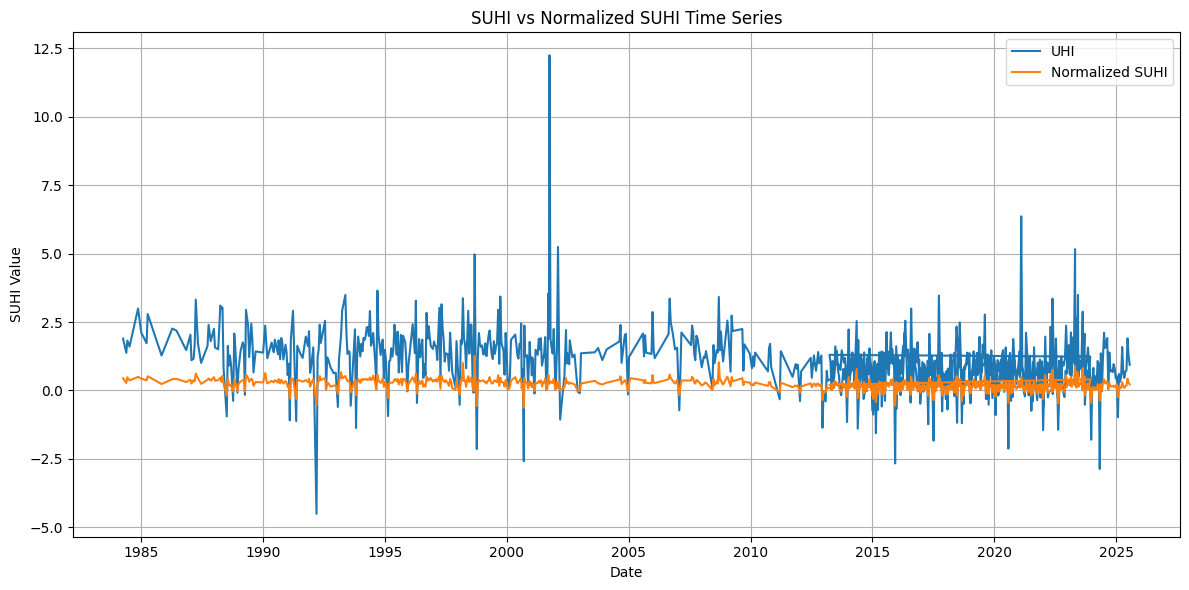

In [22]:
#plot Csv 
df_suhi = pd.read_csv('suhi_timeseries.csv', parse_dates=['DATE_ACQUIRED'])
df_suhi_norm = pd.read_csv('suhi_norm_timeseries.csv', parse_dates=['DATE_ACQUIRED'])

plt.figure(figsize=(12,6))
plt.plot(df_suhi['DATE_ACQUIRED'], df_suhi['SUHI'], label='UHI')
plt.plot(df_suhi_norm['DATE_ACQUIRED'], df_suhi_norm['SUHI_normalized'], label='Normalized SUHI')
plt.xlabel('Date')
plt.ylabel('SUHI Value')
plt.title('SUHI vs Normalized SUHI Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
